In [1]:
import numpy as np

# 全局参数
NX, NY = 100, 100  # 网格尺寸
DX, DY = 0.01, 0.01  # 网格步长
DT = 0.001  # 时间步长
C = 1.0  # 波速
VOL = DX * DY

# 定义方向和权重
DIR = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])
DS = np.array([DY, DY, DX, DX])

R = 1.0
G = (1 - R) / (1 + R)


def peak(x):
    """高斯分布函数"""
    r2 = x * x
    eps = 0.2
    eps2 = eps * eps
    if r2 / eps2 < 1.:
        return (1. - r2 / eps2) ** 4
    return 0.


def exact_sol(xy, t):
    """计算初始解"""
    x, y = xy
    r = np.sqrt((x - 0.5) ** 2 + (y - 0.5) ** 2)
    return peak(r)


def source(x, t):
    """计算源项"""
    xm, ym = 0.25, 0.25
    r = 0.1
    d = np.sqrt((x[0] - xm) ** 2 + (x[1] - ym) ** 2)
    if d < r:
        return np.sin(10 * 2 * np.pi * (np.sqrt(2) * C * t))
    return 0.


def init_sol(NX, NY, DX, DY):
    """初始化解"""
    un = np.zeros((NX, NY))
    unm1 = np.zeros((NX, NY))
    for i in range(NX):
        for j in range(NY):
            xy = np.array([i * DX, j * DY])
            un[j, i] = exact_sol(xy, 0)
            unm1[j, i] = exact_sol(xy, DT)
    return un, unm1


def time_step(tnow, un, unm1):
    """时间推进"""
    unp1 = np.zeros_like(un)
    bx = C * DT / DX
    by = C * DT / DY

    for i in range(NX):
        for j in range(NY):
            # 边界条件
            a = 1.0
            if i == 0 or i == NX - 1:
                a = 1 / (1 + bx * G)
            if j == 0 or j == NY - 1:
                a = 1 / (1 + by * G)

            # 邻居值
            u = [0.0] * 4
            for d, (di, dj) in enumerate(DIR):
                iR = i + di
                jR = j + dj
                if iR < 0: iR = 1
                if iR >= NX: iR = NX - 2
                if jR < 0: jR = 1
                if jR >= NY: jR = NY - 2
                u[d] = un[jR, iR]

            # 当前网格值
            xy = np.array([i * DX, j * DY])
            s = source(xy, tnow)

            # 更新公式
            unp1[j, i] = (1 - 2 * a) * unm1[j, i] + \
                         2 * a * (1 - bx ** 2 - by ** 2) * un[j, i] + \
                         a * bx ** 2 * (u[0] + u[1]) + \
                         a * by ** 2 * (u[2] + u[3]) - \
                         DT ** 2 * a * s

    return unp1


# 初始化
un, unm1 = init_sol(NX, NY, DX, DY)

# 时间推进
TMAX = 1.0  # 最大时间
steps = int(TMAX / DT)

for step in range(steps):
    tnow = step * DT
    unp1 = time_step(tnow, un, unm1)
    unm1, un = un, unp1  # 滚动更新

# 打印最终结果
print("模拟完成，最后时刻的解：")
print(un)

模拟完成，最后时刻的解：
[[-0.04906867 -0.04906256 -0.04911924 ... -0.04769317 -0.04749705
  -0.04742885]
 [-0.04906256 -0.04908875 -0.04920422 ... -0.04776422 -0.04752978
  -0.04744808]
 [-0.04911924 -0.04920422 -0.04944429 ... -0.04796396 -0.04765867
  -0.04754468]
 ...
 [-0.04769317 -0.04776422 -0.04796396 ... -0.04635076 -0.0462163
  -0.04617542]
 [-0.04749705 -0.04752978 -0.04765867 ... -0.0462163  -0.04605906
  -0.04600052]
 [-0.04742885 -0.04744808 -0.04754468 ... -0.04617542 -0.04600052
  -0.04593162]]


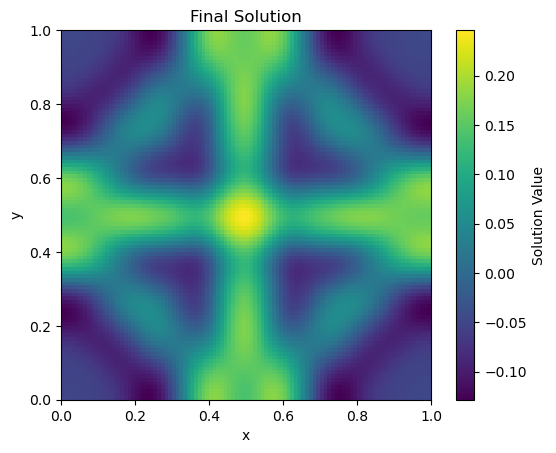

In [2]:
import matplotlib.pyplot as plt

plt.imshow(un, extent=[0, NX * DX, 0, NY * DY], origin='lower', cmap='viridis')
plt.colorbar(label='Solution Value')
plt.title('Final Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

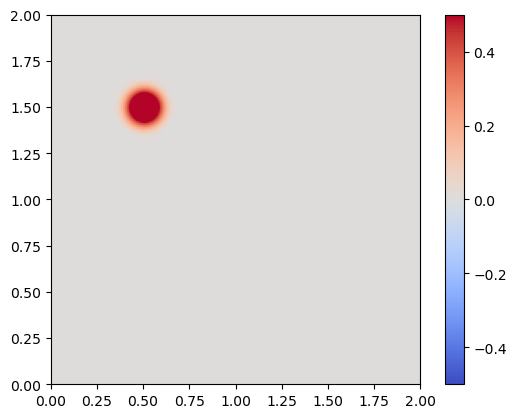

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 物理参数
NX, NY = 200, 200  # 网格点数
DX = DY = 0.01     # 空间步长
DT = 0.005         # 时间步长
C = 1.0            # 波速
R = 0.99           # 边界反射系数
G = (1 - R) / (1 + R)

# 计算域
x = np.linspace(0, NX*DX, NX)
y = np.linspace(0, NY*DY, NY)
X, Y = np.meshgrid(x, y)

# 初始化数组
unm1 = np.zeros((NY, NX))  # u^{n-1}
un = np.zeros((NY, NX))    # u^n
unp1 = np.zeros((NY, NX))  # u^{n+1}

# 方向向量
dirs = [(-1,0), (1,0), (0,-1), (0,1)]
ds = [DY, DY, DX, DX]

def exact_solution(xy, t):
    x, y = xy
    r = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    return peak(r)

def peak(r):
    eps = 0.2
    r2 = (r/eps)**2
    return np.where(r2 < 1, (1 - r2)**4, 0)

def source(xy, t):
    x, y = xy
    xm, ym = 0.25, 0.25
    r = 0.1
    d = np.sqrt((x - xm)**2 + (y - ym)**2)
    return np.where(d < r, np.sin(10*2*np.pi*np.sqrt(2)*C*t), 0)

# 初始化
for j in range(NY):
    for i in range(NX):
        xy = (i*DX, j*DY)
        unm1[j,i] = exact_solution(xy, 0)
        un[j,i] = exact_solution(xy, DT)

def update_boundary(u):
    # 吸收边界条件
    u[0,:]  = u[1,:] * G   # 上边界
    u[-1,:] = u[-2,:] * G  # 下边界
    u[:,0]  = u[:,1] * G   # 左边界
    u[:,-1] = u[:,-2] * G  # 右边界

def time_step(t):
    global unm1, un, unp1
    bx = C * DT / DX
    by = C * DT / DY
    
    for j in range(1, NY-1):
        for i in range(1, NX-1):
            # 收集邻居值
            u_neighbors = [
                un[j + dj, i + di] for di, dj in dirs
            ]
            
            # 计算源项
            s = source((i*DX, j*DY), t)
            
            # 更新公式
            a = 1.0
            term1 = (1 - 2*a) * unm1[j,i]
            term2 = 2*a*(1 - bx**2 - by**2)*un[j,i]
            term3 = a*bx**2*(u_neighbors[0] + u_neighbors[1])
            term4 = a*by**2*(u_neighbors[2] + u_neighbors[3])
            term5 = (DT**2)*a*s  # 修正符号
            
            unp1[j,i] = term1 + term2 + term3 + term4 + term5
    
    # 更新边界
    update_boundary(unp1)
    
    # 滚动数组
    unm1, un, unp1 = un, unp1, unm1

# 可视化设置
fig, ax = plt.subplots()
im = ax.imshow(un, extent=[0, NX*DX, 0, NY*DY], 
              cmap='coolwarm', vmin=-0.5, vmax=0.5)
plt.colorbar(im)

def animate(frame):
    time_step(frame*DT)
    im.set_data(un)
    im.set_clim(vmin=un.min(), vmax=un.max())
    ax.set_title(f"Time: {frame*DT:.3f}s")
    return im,

# 运行动画
ani = FuncAnimation(fig, animate, frames=200, interval=50)
plt.show()